In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path as osp
import os
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform


# Working with fine-grained image classification

This notebook shall go through an idea of beating the benchmark for the MAFAT Challenge using the Classification of Fine-Grained Features In Aerial Image (COFGA) dataset. Initially the study shall replicate the results given in the paper: **Dahan, Eran, and Tzvi Diskin. "COFGA: Classification Of Fine-Grained Features In Aerial Images." arXiv preprint arXiv:1808.09001 (2018).**

*Inspired from PyTorch tutorials.*

## Initial loading of data and pre-processing steps
First we shall load the data, and prepare it for the neural networks.

The key steps in pre-processing images is as follows:
- Normalising the intensities by subtracting the mean and dividing with 255 on all channels
- Ensuring tensor conforms with expected input
- Ensuring labels conform with expected output

Initially, let us load the data and visualise some of the data in the dataset

In [10]:
train = pd.read_csv('./dataset_v2/train.csv')
valid = pd.read_csv('./dataset_v2/test.csv')

In [11]:
train.dtypes

tag_id                   int64
image_id                 int64
p1_x                   float64
p_1y                   float64
 p2_x                  float64
 p2_y                  float64
 p3_x                  float64
 p3_y                  float64
 p4_x                  float64
 p4_y                  float64
general_class           object
sub_class               object
sunroof                  int64
luggage_carrier          int64
open_cargo_area          int64
enclosed_cab             int64
spare_wheel              int64
wrecked                  int64
flatbed                  int64
ladder                   int64
enclosed_box             int64
soft_shell_box           int64
harnessed_to_a_cart      int64
ac_vents                 int64
color                   object
dtype: object

In [12]:
train[1:4].T

,1,2,3
tag_id,31658,26971,19301
image_id,16490,17122,12193
p1_x,3380.8,3948.33,1977.8
p_1y,33.3709,1426.8,1009.01
p2_x,3329.81,3958.88,1983.44
p2_y,128.465,1410.75,992.097
p3_x,3358.06,4000.67,2034.18
p3_y,142.936,1438.2,1009.01
p4_x,3409.06,3990.12,2027.91
p4_y,44.3964,1454.25,1027.18


Note that there are space and other unwanted characters in the labels. We'll replace these with underscore

In [13]:
train.replace(' ', '_', regex=True,inplace=True)
train.replace('/', '_', regex=True,inplace=True)
valid.replace(' ', '_', regex=True,inplace=True)
valid.replace('/', '_', regex=True,inplace=True)
train[1:4].T

,1,2,3
tag_id,31658,26971,19301
image_id,16490,17122,12193
p1_x,3380.8,3948.33,1977.8
p_1y,33.3709,1426.8,1009.01
p2_x,3329.81,3958.88,1983.44
p2_y,128.465,1410.75,992.097
p3_x,3358.06,4000.67,2034.18
p3_y,142.936,1438.2,1009.01
p4_x,3409.06,3990.12,2027.91
p4_y,44.3964,1454.25,1027.18


# Helper functions

In [14]:
class MAFAT_Dataset(Dataset):
    """MAFAT dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.metadata = pd.read_csv(csv_file)
        self.root_dir = root_dir
#         self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        img_name = getFileName(name=str(self.metadata.iloc[idx, 1]),filesPath=self.root_dir)
        image = io.imread(img_name)
        xyPoints = self.metadata.iloc[idx, 2:10].values #xy-coordinates, a maxiumum of 4 objects per image
        xyPoints = xyPoints.astype('float').reshape(-1, 2)
        xyRaw = self.metadata.iloc[idx, 2:10].values
        xyRaw = xyRaw.astype('float')
        sample = {'image': image, 'xypoints': xyPoints,'xyRaw': xyRaw,'filename': str(self.metadata.iloc[idx, 1]),
                 'tagid': str(self.metadata.iloc[idx, 0]),'OOB_object': 'None'}
        
        return sample
    

In [15]:

def getFileName(filesPath = None,name = None):
    """
    Returns the full name of image given a path and unique string identifying file
    """
    for root, dirs, files in os.walk(filesPath):
        name = str(name) #ensure
        filename = "".join(s for s in files if name in s) #get filename in folder
        return os.path.join(root, filename) #get full string
    
def show_landmarks(image, xypoints):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(xypoints[:, 0], xypoints[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated
    plt.figure()
    plt.show()

def cropIm(im,xvec,yvec,pad,imExtent):
    """
        Crop image
    """
    assert pad >= 0, "Padding must be positive"
    boxlowx = int(min(xvec)-pad)
    boxlowy = int(min(yvec)-pad)
    boxhix = int(max(xvec)+pad)
    boxhiy = int(max(yvec)+pad)
    im = im[boxlowy:boxhiy,boxlowx:boxhix,:] #Ensuring images are square
    return im    

def cropPolygonImage(image,xvec,yvec,pad,root,filename,pltIm=None,fixedshape=64):
    """
        Crops image based on set of coordinates
    """
    from PIL import Image,ImageDraw
    assert image.shape[2] >= 3, 'Image requires alpha layer in forth channel' 
    polygon = [(xvec[0],yvec[0]),(xvec[1],yvec[1]),(xvec[2],yvec[2]),(xvec[3],yvec[3])]
    maskIm = Image.new('L', (image.shape[1], image.shape[0]), 0)
    ImageDraw.Draw(maskIm).polygon(polygon, outline=1, fill=1)
    mask = np.array(maskIm)

    # assemble new image (uint8: 0-255)
    newImArray = np.empty(image.shape,dtype='uint8')

    # colors (three first columns, RGB)
    newImArray[:,:,:3] = image[:,:,:3]

    # transparency (4th column)
    newImArray[:,:,3] = mask*255

    # back to Image from numpy
    croppedImage = cropIm(newImArray,xvec=xvec,yvec=yvec,pad=pad,imExtent=fixedshape)
    newIm = Image.fromarray(croppedImage, "RGBA")
    newIm = newIm.resize((256,256),Image.BICUBIC)
    newIm.save(osp.join(root,'cropped/',filename))
    if pltIm is not None:
        plt.imshow(croppedImage)
        plt.show()
    
dataset = MAFAT_Dataset(csv_file='./dataset/train.csv',
                                    root_dir='dataset/root/train/')

def copyToClassFolders(listOfClasses,rootPath=None,df=None):
    """
        Copies cropped images and assigns them to folder representative of that feature/class
    """
    import shutil
    import difflib
    list_of_cropped_images=os.listdir(rootPath+'cropped/')
    ims = 0
    errorIm=0
    classCols=df.columns[12:-1]
    for image in list_of_cropped_images: # loop over the cropped images
        s = str(image)
        s = s.replace('.png','')
        s = s.split('_') #split into image_id and tag_id
        try:
            dataRow = df[df.tag_id == int(s[1])]
        except:
            print('unexpected file type')
            continue
        if not dataRow.empty:
            feat = dataRow #get only the  class features
            for i in range(10,25):
                val = feat.iloc[0,i]
                if isinstance(val,str) is True: #type of general class
                    shutil.copy2(rootPath+'cropped/'+image, rootPath+'classes/'+val) 
                if i > 11  and i < 24:            
                    if int(val) > 0:
                        item = i-12
                        match = difflib.get_close_matches(str(classCols[item]),listOfClasses,n=1)[0]
                        shutil.copy2(rootPath+'cropped/'+image, rootPath+'classes/'+match)
        else:
            errorIm+=1
            if errorIm % 100 ==0:
                print(errorIm)
        ims+=1
        if ims % 250 == 0:
            print(f'Images copied: {ims}')                 


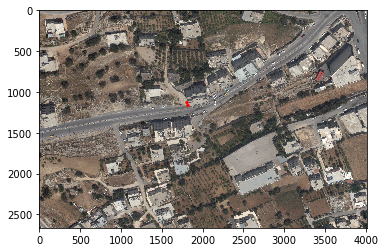

<Figure size 432x288 with 0 Axes>

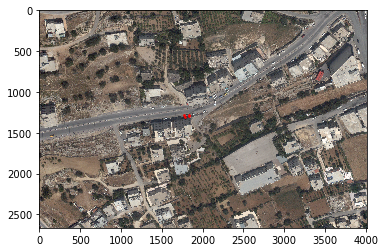

<Figure size 432x288 with 0 Axes>

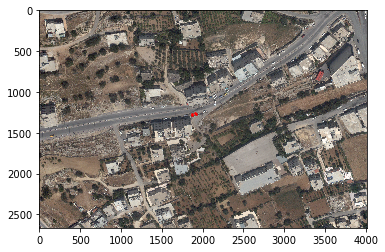

<Figure size 432x288 with 0 Axes>

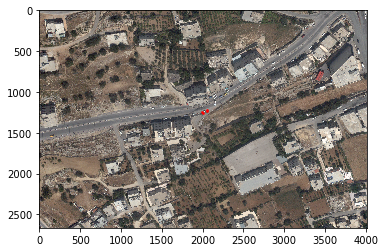

<Figure size 432x288 with 0 Axes>

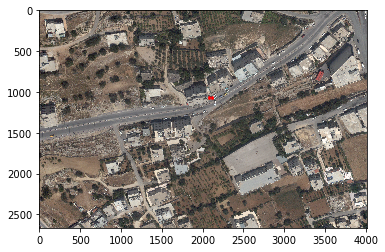

<Figure size 432x288 with 0 Axes>

In [16]:
#Visualize 5 tagged objects
numTags = 5
for i in range(0,5):
    show_landmarks(dataset[i]['image'],xypoints=dataset[i]['xypoints'])

In [17]:
def generateCroppedImages(dataset,imDir,pltIm=None):
    """
    Generates cropped images based on bounding box presented as a tag_id
    args:
        input: 
                dataset - Dataset of the MAFAT_Dataset class
                imDir - Root of all images 
                pltIm - If true plots cropped result
                
    """
    i=0
    
    import os
    if not os.path.exists(f'{imDir}/cropped/'):
        os.makedirs(f'{imDir}/cropped/')
    
    for entry in dataset:
        entry = dataset[i]
        filename = entry['filename']+'_'+entry['tagid']+'.png'
        xy = entry['xyRaw']
        imnext = entry['image']
        imnext = np.concatenate((imnext,np.ones(imnext.shape[:-1]+(1,))*255),axis=-1) ## Add alpha for polygon cropping
        xvec = [xy[0],xy[2],xy[4],xy[6]]
        yvec = [xy[1],xy[3],xy[5],xy[7]]
        
        try:
            cropPolygonImage(imnext,xvec,yvec,0,imDir,filename=filename,pltIm=pltIm)
        except:
            print('Warning: Object out of bounds, filename: %s',filename,'\n Iteration no:',i)
            dataset[i]['OOB_object'] = filename
        i+=1
        if i % 100 == 0:
            print(i)

In [18]:
dataset = MAFAT_Dataset(csv_file='./dataset_v2/train.csv',root_dir='dataset_v2/root/train/')
imDir = './dataset_v2/root/train/'

# Note the next operation takes quite a while

In [19]:
generateCroppedImages(dataset=dataset,imDir=imDir)

KeyboardInterrupt: 

# Visualising the cropped results
The outputted cropped images are hereafter located in the 'cropped/'-folder
We can visualize how the expected results should look like by examining the following plots

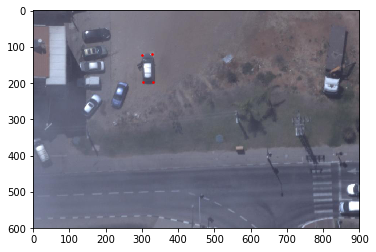

<Figure size 432x288 with 0 Axes>

In [20]:
 show_landmarks(dataset[53]['image'],xypoints=dataset[53]['xypoints'])

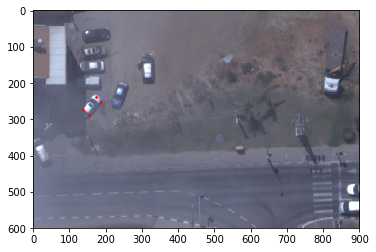

<Figure size 432x288 with 0 Axes>

In [21]:
 show_landmarks(dataset[54]['image'],xypoints=dataset[54]['xypoints'])

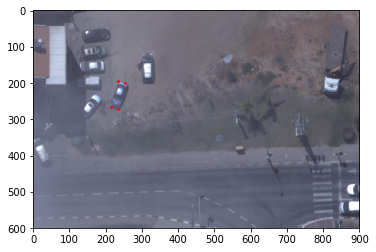

<Figure size 432x288 with 0 Axes>

In [22]:
 show_landmarks(dataset[52]['image'],xypoints=dataset[52]['xypoints'])

Such that for each of the above tags, we crop the .TIF files into smaller .PNG files representative of the extent form by the four point coordinates given by the tag. One should try and play around with dilation, since it is aparaent that in some cases the extent of the polygon is too tight. 

Futhermore, several of the annotated objects cross boundaries with other .TIF files. This is not handled at the moment, and such tags are simply excluded from the dataset.

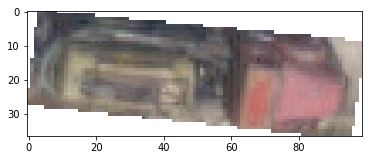

In [23]:
entry = dataset[i]
filename = entry['filename']+'_'+entry['tagid']+'.png'
xy = entry['xyRaw']
imnext = entry['image']
imnext = np.concatenate((imnext,np.ones(imnext.shape[:-1]+(1,))*255),axis=-1) ## Add alpha for polygon cropping

xvec = [xy[0],xy[2],xy[4],xy[6]]
yvec = [xy[1],xy[3],xy[5],xy[7]]
cropPolygonImage(imnext,xvec,yvec,0,'./dataset/root/train/',filename=filename,pltIm=True)

# Outputting images into class folders

Now that the images are cropped, we may organise each of the tagged objects into folder representative of the class and feature combinations formed by the class. 

In [24]:
list_of_cropped_images=os.listdir('./dataset_v2/root/train/cropped/')

In [25]:
# Get all classes/features 
listOfClasses = train.iloc[:,10].unique().tolist()
listOfClasses.extend(train.iloc[:,11].unique().tolist())
listOfClasses.extend(train.columns[12:-1].tolist())
listOfClasses.extend(train.iloc[:,-1].unique().tolist())

In [26]:
listOfClasses

['small_vehicle',
 'large_vehicle',
 'sedan',
 'truck',
 'dedicated_agricultural_vehicle',
 'jeep',
 'crane_truck',
 'prime_mover',
 'cement_mixer',
 'hatchback',
 'minivan',
 'pickup',
 'van',
 'light_truck',
 'bus',
 'tanker',
 'minibus',
 'sunroof',
 'luggage_carrier',
 'open_cargo_area',
 'enclosed_cab',
 'spare_wheel',
 'wrecked',
 'flatbed',
 'ladder',
 'enclosed_box',
 'soft_shell_box',
 'harnessed_to_a_cart',
 'ac_vents',
 'black',
 'red',
 'silver_grey',
 'blue',
 'yellow',
 'green',
 'white',
 'other']

In [29]:
rootPath = './dataset_v2/root/train/classes/'
os.mkdir(rootPath)
for cls in listOfClasses:
    os.mkdir(f'{rootPath}{cls}')

# Copy images to folders

In [30]:
copyToClassFolders(listOfClasses,rootPath='./dataset_v2/root/train/',df=train)

Images copied: 250
Images copied: 500


KeyboardInterrupt: 

Now all folders should have a file corresponding to the class/feature combination it matches. The same procedure should be completed with the validation .CSV file